# **Part 2 - Price prediction using Natural Language Processing (NLP)**

In Part 1, I used attributes of Les Paul models to predict the retail price. This approach worked in principle but the model error was too large to be useful. A better approach would be to use the product description to identify key pieces of text which would allude to the price. For example, a basic guitar might have a very simplistic product description but an expensive guitar could have some unique keywords which would allude to a higher price tag. With this in mind, let's try NLP to predict guitar prices!

## Extract, transform, load (ETL) pipeline
Data engineering relies on (1) extraction of data from different sources, (2) transformation of the raw data into useful features, and (3) loading the data into a database. I made a `Scrapy` spider to extract guitar product descriptions, model names, and prices from the *Thomann* website (which I have already run and saved the data as a CSV file in the `guitar_scraper` directory). In step 2, we will format the price data from string to integer format and run some NLP techniques on the product descriptions, before carrying out step 3 where the transformed data will be saved in a local database.

In [114]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
nltk.download(["punkt", "wordnet", "stopwords"])

raw = pd.read_csv("../guitar_scraper/guitar_info.csv")
unique_urls = raw['url'].unique().shape[0]
unique_desc = raw['description'].unique().shape[0]

print(f"{unique_urls} unique urls")
print(f"{unique_desc} unique descriptions")
print(f"{unique_urls - unique_desc} duplicate descriptions")
print("\nRaw data:")
print(raw.iloc[445, :])

4317 unique urls
3973 unique descriptions
344 duplicate descriptions

Raw data:
description    Custom Shop George Harrison "Rocky" Signature ...
name                         Fender George Harrison "Rocky" MBPW
price                                                    €26,590
url            https://www.thomann.de/ie/fender_george_harris...
Name: 445, dtype: object


[nltk_data] Downloading package punkt to /home/martin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/martin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/martin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Product listings for a particular guitar model should be the same, so it is expected that there are some duplicate descriptions in the raw data. These guitars should only differ in terms of colour so we'll keep them in the dataset for now. To begin formatting our data, let's first convert the price column to integer format.

In [3]:
# copy the raw data to separate dataframe
df = raw.copy()

# transform the price column
df["price"] = df["price"].apply(lambda x: int(x[1:].replace(",", "")))

To process the text data, I'm borrowing a function I used for a different NLP project.

In [4]:
def tokenize(text):
    """
    Process raw text into tokenized data for training (feature extraction)

    Parameters
    ----------
    text : string
        tweet in string format

    Returns
    -------
    cleaned_tokens : list of tokenized strings

    """
    # convert to lower case and only keep alphanumeric characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # split string into word tokens
    tokens = word_tokenize(text)
    # remove inflections of words with similar meaning
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    cleaned_tokens = []
    for token in tokens:
        if token not in stop_words:
            clean = lemmatizer.lemmatize(token).lower().strip()
            cleaned_tokens.append(clean)
    return cleaned_tokens

tokens = tokenize(df["description"][445])

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(df["description"])
feature_names = vectorizer.get_feature_names()
X = X.toarray()
print(f"Created {X.shape[1]} features from {df.shape[0]} observations")

Created 5083 features from 4317 observations


It's great that we can extract so many features from a small set of data, but having more features than observations means there could be a unique combination for every guitar in our dataset!
To combat this, let's use Principal Component Analysis (PCA) to select those features which account for the most variability in our data.

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# split data into training and test sets before running PCA
X_train, X_test, y_train, y_test = train_test_split(X, df["price"], test_size=0.3,
                                                    shuffle=True, random_state=42)

pca = PCA(n_components=3021)
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

Text(0.5, 1.0, '300 features explain 82.40% of the variance')

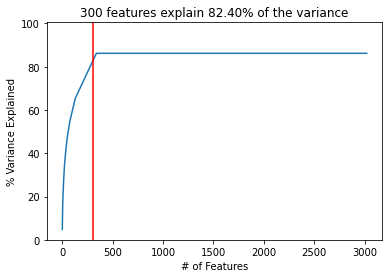

In [7]:
# calculate variance ratios
variance = pca.explained_variance_ratio_

# cumulative sum of variance explained with [n] features
n = 300
var = np.cumsum(np.round(variance, decimals=3)*100)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.axvline(n, c="r")
plt.title(f"{n} features explain {var[n-1]:.2f}% of the variance")

The PCA results tell us that 300 features can explain over 80% of the variance in the our data. 300 features from the `X_train` data containing 3021 observations is roughly 10 observations per feature which is just enough to agree with the general guidelines for the usable number of features when training ML models. Let's now take these features and train a tree-based ensemble model to predict guitar prices.

In [100]:
X_train_300 = X_train_scaled[:, :300]
X_test_300 = X_test_scaled[:, :300]

clf = GradientBoostingRegressor()
clf.fit(X_train_300, y_train)
clf.score(X_test_300, y_test)

0.41465359541301205

In [126]:
def predict(clf, num, test_data):
    try:
        pred = clf.predict([test_data[num]])[0]
    except KeyError:
        pred = clf.predict([test_data.iloc[num, :]])[0]
    true = y_test.tolist()[num]
    error = pred - true
    print(f"\nActual price {true}")
    print(f"Predicted price {pred:.2f}")
    if error > 1:
        print(f"Overpredicted price by {error:.2f}")
    else:
        print(f"Under-predicted price by {error * -1:.2f}")
        
def cat_error(x):
    if x < 500:
        return "<500"
    elif 500 <= x < 1000:
        return "500-1000"
    elif 1000 <= x < 2000:
        return "1000-2000"
    else:
        return "<2000"
    
def plot_predictions(clf, test_data, test_y):
    results = clf.predict(test_data)
    error = results - test_y

    data = pd.DataFrame({"actual" : test_y, "predicted" : results, "error" : error})
    data["% error"] = np.abs(data["error"]) / data["actual"] * 100
    data["error_cat"] = data["error"].apply(lambda x: cat_error(abs(x)))
    
    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    sns.scatterplot(x="actual", y="predicted", data=data, hue="error_cat")
    plt.subplot(132)
    sns.countplot(x=data["error_cat"])
    plt.subplot(133)
    sns.violinplot(y=data["% error"], inner="quartile", cut=0)
    plt.ylim(-0.5, 100.5)
    over_100 = np.sum(data["% error"] > 100) / data.shape[0] * 100
    plt.title(f"{over_100:.1f}% observations with error > 100%")

    perc_over = np.where(data["error"] > 1, 1, 0).mean() * 100
    mae = mean_absolute_error(test_y, results)
    print(f"\n{perc_over:.2f}% of guitar prices were over-predicted")
    print(f"MAE\t{mae:.2f}")


Actual price 1265
Predicted price 1558.88
Overpredicted price by 293.88

Actual price 1022
Predicted price 1926.68
Overpredicted price by 904.68

Actual price 2299
Predicted price 1640.05
Under-predicted price by 658.95

62.65% of guitar prices were over-predicted
MAE	952.27


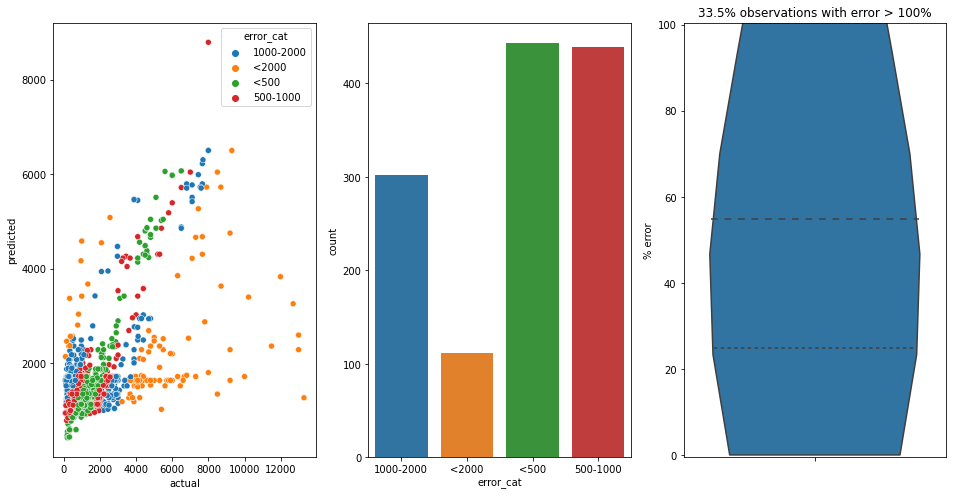

In [127]:
predict(clf, 10, X_test_300)
predict(clf, 100, X_test_300)
predict(clf, 1000, X_test_300)
plot_predictions(clf, X_test_300, y_test)

In [128]:
df1 = pd.read_csv("../Part 1 - Prediction from guitar features/dummied_lp_product_data.csv")
X1 = df1.iloc[:, 9:]
y1 = df1["price"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3,
                                                        shuffle=True, random_state=42)

clf1 = GradientBoostingRegressor()
clf1.fit(X1_train, y1_train)
clf1.score(X1_test, y1_test)

0.7544634344912136


Actual price 2555
Predicted price 1524.90
Under-predicted price by 1030.10

Actual price 1022
Predicted price 4399.24
Overpredicted price by 3377.24

Actual price 179
Predicted price 2530.75
Overpredicted price by 2351.75

53.70% of guitar prices were over-predicted
MAE	624.33


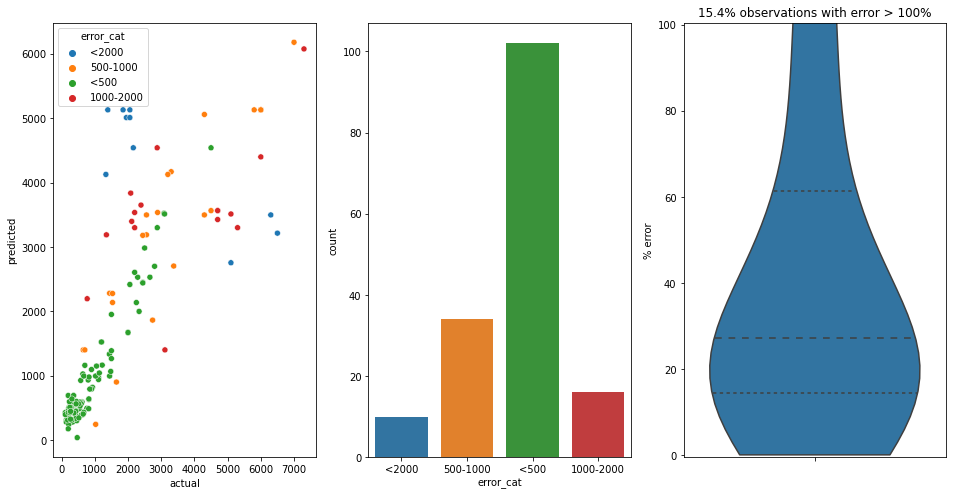

In [129]:
predict(clf1, 50, X1_test)
predict(clf1, 100, X1_test)
predict(clf1, 150, X1_test)
plot_predictions(clf1, X1_test, y1_test)

### Knowledge summary
* PCA is a powerful tool for dimensionality reduction
* A targeted approach with domain knowledge is key to identifying powerful features
* One model is insufficient to predict guitar prices when the types of guitars vary widely by construction, and artist endorsement